<a href="https://colab.research.google.com/github/davinnnnn/Fine-tuning/blob/main/transfer_learning_tutorial_ipynb_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyTorch의 Google Colab에서의 노트북 실행 팁에 대한 링크 제공
# 주석은 '#'으로 시작하며, 실행되지 않는 설명문입니다.
# Google Colab에서 노트북을 실행하는 팁은 아래 링크에서 확인할 수 있습니다.
# https://pytorch.org/tutorials/beginner/colab

# matplotlib로 생성된 그래프를 노트북 셀 내부에 직접 표시하기 위한 설정
%matplotlib inline


# 컴퓨터 비전을 위한 전이 학습 튜토리얼

저자: Sasank Chilamkurthy
이 튜토리얼에서는 전이 학습을 사용하여 이미지 분류를 위한 합성곱 신경망을 훈련시키는 방법을 배울 수 있습니다. cs231n 노트  [cs231n notes](https://cs231n.github.io/transfer-learning/)에서 전이 학습에 대한 더 자세한 내용을 읽을 수 있습니다.
이 노트에서 인용하면,


    실제로 대부분의 사람들은 충분한 크기의 데이터셋을 갖고 있지 않기 때문에 처음부터 전체 합성곱 네트워크를 훈련시키지 않습니다(무작위 초기화를 통해). 대신, 매우 큰 데이터셋(예: ImageNet, 1000개의 카테고리로 120만 개의 이미지가 포함된)에서 ConvNet을 사전 훈련시키는 것이 일반적입니다. 그 다음 관심 분야의 작업을 위해 ConvNet을 초기화나 고정된 특징 추출기로 사용합니다.

다음은 전이 학습의 두 가지 주요 시나리오에 대한 설명입니다:

ConvNet 미세 조정: 무작위 초기화 대신 ImageNet 1000 데이터셋에서 훈련된 네트워크와 같은 사전 훈련된 네트워크로 네트워크를 초기화합니다. 그 외의 훈련은 평소와 같습니다.
고정 특징 추출기로서의 ConvNet: 여기에서는 최종 완전 연결 계층을 제외한 네트워크의 모든 가중치를 고정합니다. 이 마지막 완전 연결 계층은 새로운 무작위 가중치를 가진 계층으로 교체되며, 오직 이 계층만이 훈련됩니다.

In [ ]:
# 라이센스: BSD
# 작성자: Sasank Chilamkurthy

# 필요한 라이브러리와 모듈들을 임포트합니다.
import torch  # PyTorch 라이브러리
import torch.nn as nn  # PyTorch의 신경망 모듈
import torch.optim as optim  # PyTorch의 최적화 알고리즘들
from torch.optim import lr_scheduler  # 학습률 스케줄러
import torch.backends.cudnn as cudnn  # CUDA 딥 러닝 라이브러리를 위한 cudnn 백엔드
import numpy as np  # 넘파이 라이브러리
import torchvision  # 컴퓨터 비전을 위한 PyTorch 라이브러리
from torchvision import datasets, models, transforms  # torchvision의 데이터셋, 모델, 변환 함수들
import matplotlib.pyplot as plt  # 그래프 및 이미지 표시를 위한 matplotlib 라이브러리
import time  # 시간 관련 함수
import os  # 운영 체제 관련 작업을 위한 라이브러리
from PIL import Image  # 이미지 처리를 위한 PIL 라이브러리
from tempfile import TemporaryDirectory  # 임시 디렉토리 생성을 위한 함수

# cudnn의 성능 최적화 옵션 활성화
cudnn.benchmark = True

# matplotlib의 인터랙티브 모드 활성화
# 이를 통해 그래프가 동적으로 업데이트 될 수 있게 됩니다.
plt.ion()


## 데이터 불러오기
torchvision 및 torch.utils.data 패키지를 사용하여 데이터를 불러올 것입니다.
오늘 우리가 해결하려는 문제는 개미와 벌을 분류하기 위해 모델을 훈련시키는 것입니다. 개미와 벌 각각에 대해 약 120개의 훈련 이미지가 있습니다. 각 클래스에 대해 75개의 검증 이미지가 있습니다. 일반적으로 이는 처음부터 훈련시킬 때 일반화하기에 매우 작은 데이터셋입니다. 그러나 우리는 전이 학습을 사용하기 때문에 합리적으로 잘 일반화할 수 있어야 합니다.
이 데이터셋은 ImageNet의 매우 작은 부분 집합입니다.
.. 주의 :: 데이터는
   [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   에서 다운로드 받아 현재 디렉터리에 압축 해제하십시오.



In [ ]:
# Jupyter 노트북이나 Google Colab에서 자동으로 생성되는 체크포인트 폴더를 삭제합니다.
!rm -R .ipynb_checkpoints

rm: cannot remove '.ipynb_checkpoints': No such file or directory


In [ ]:
# 훈련 데이터에 대한 데이터 증강 및 정규화 설정
# 검증 데이터에 대해서는 오직 정규화만 적용
data_transforms = {
    'train': transforms.Compose([  # 훈련 데이터에 적용할 변환들
        transforms.RandomResizedCrop(224),  # 무작위 크기 및 비율로 잘라낸 후, 224x224 크기로 변환
        transforms.RandomHorizontalFlip(),   # 50% 확률로 이미지를 수평으로 뒤집기
        transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화 (평균 및 표준편차)
    ]),
    'val': transforms.Compose([  # 검증 데이터에 적용할 변환들
        transforms.Resize(256),  # 256x256 크기로 변환
        transforms.CenterCrop(224),  # 이미지 중앙을 기준으로 224x224 크기로 잘라내기
        transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화 (평균 및 표준편차)
    ]),
}

# 데이터셋의 경로 설정
data_dir = '/content/drive/MyDrive/data /hymenoptera_data'

# 이미지 데이터셋 로드 및 설정된 변환 적용
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# 데이터 로더 설정 (배치 크기, 섞기, 병렬 처리)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# 각 데이터셋의 크기 계산
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 훈련 데이터셋의 클래스 이름 가져오기
class_names = image_datasets['train'].classes

# 현재 시스템에서 GPU(CUDA) 지원이 가능한지 확인하고, 가능하면 GPU를 사용하도록 설정합니다. 만약 GPU 지원이 불가능하면, CPU를 사용하도록 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Google Colab에서 Google 드라이브를 연동하기 위한 라이브러리 임포트
from google.colab import drive

# Google 드라이브를 현재 Colab 환경에 '/content/drive' 경로로 마운트
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 몇몇 이미지 시각화하기
데이터 증강을 이해하기 위해 몇몇 훈련 이미지를 시각화해봅시다.



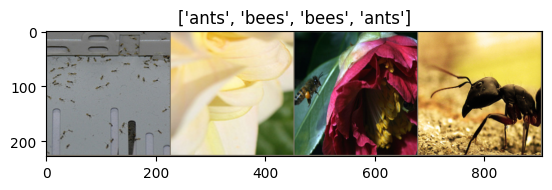

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    # 텐서를 넘파이 배열로 변환하고 차원을 변경 (C x H x W) -> (H x W x C)
    inp = inp.numpy().transpose((1, 2, 0))
    # 정규화를 위한 평균 및 표준편차 값
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # 이미지를 원래의 범위로 역정규화
    inp = std * inp + mean
    # 값을 0과 1 사이로 클리핑하여 이미지로서 보여줄 수 있도록 함
    inp = np.clip(inp, 0, 1)
    # 이미지 표시
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # 플롯이 업데이트될 수 있도록 잠시 일시정지
    plt.pause(0.001)

# 훈련 데이터셋에서 배치 하나를 가져옴
inputs, classes = next(iter(dataloaders['train']))

# 배치에서 이미지들을 격자 형태로 만듦
out = torchvision.utils.make_grid(inputs)

# 격자 형태의 이미지를 표시하며, 각 이미지에 대한 클래스 이름을 제목으로 함
imshow(out, title=[class_names[x] for x in classes])


## 모델 훈련하기

이제 모델을 훈련시키는 일반적인 함수를 작성해봅시다. 여기에서는 다음과 같은 내용을 다룰 것입니다:

학습률(learning rate) 스케줄링
최적의 모델 저장하기
아래에서의 scheduler 매개변수는 torch.optim.lr_scheduler로부터의 LR 스케줄러 객체입니다.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # 훈련 시작 시간을 기록
    since = time.time()

    # 훈련 중간에 체크포인트(최적의 모델 파라미터)를 임시로 저장할 디렉터리 생성
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # 현재 모델의 상태를 체크포인트 경로에 저장 (이후에 최고의 모델로 업데이트 될 수 있음)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0  # 현재까지의 최고 검증 정확도

        # 전체 epoch만큼 반복하여 훈련
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # 각 epoch는 훈련 데이터와 검증 데이터에 대한 두 단계로 구성됨
            for phase in ['train', 'val']:
                # 모델을 훈련 모드 또는 평가 모드로 설정
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                # 각 단계별 누적 손실 및 올바른 예측 수 초기화
                running_loss = 0.0
                running_corrects = 0

                # 데이터로더에서 배치 데이터를 순차적으로 가져옴
                for inputs, labels in dataloaders[phase]:
                    # 데이터와 레이블을 현재 작업 중인 장치(CPU or GPU)로 이동
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 이전에 계산된 기울기를 초기화
                    optimizer.zero_grad()

                    # 순전파
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)  # 모델의 예측 값 계산
                        _, preds = torch.max(outputs, 1)  # 가장 확률이 높은 클래스 예측
                        loss = criterion(outputs, labels)  # 예측 값과 실제 레이블 간의 손실 계산

                        # 훈련 모드에서만 역전파 및 파라미터 업데이트 수행
                        if phase == 'train':
                            loss.backward()  # 기울기 계산
                            optimizer.step()  # 파라미터 업데이트

                    # 배치별 손실 및 정확도 통계 업데이트
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Learning rate scheduler 갱신 (주로 훈련 단계에서 사용됨)
                if phase == 'train':
                    scheduler.step()

                # 전체 데이터에 대한 평균 손실 및 정확도 계산
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # 결과 출력
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 검증 단계에서 현재의 모델이 최고 성능을 가질 경우, 체크포인트 업데이트
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            print()

        # 전체 훈련 시간 계산 및 출력
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # 최고의 검증 정확도를 달성한 모델의 가중치를 로드
        model.load_state_dict(torch.load(best_model_params_path))
    return model


### 모델 예측 시각화하기
몇 개의 이미지에 대한 예측을 표시하는 일반적인 함수

이 부분은 주어진 모델을 사용하여 이미지를 예측하고 그 결과를 시각적으로 표시하기 위한 기능을 설명합니다. 여기서 "일반적인 함수"라는 표현은 특정 데이터셋이나 모델 아키텍처에 구애받지 않고 여러 상황에서 활용할 수 있는 범용적인 함수를 의미합니다. 이러한 함수를 사용하면 모델의 예측이 실제 데이터와 얼마나 잘 일치하는지를 이미지 형태로 직접 확인할 수 있어, 모델의 성능을 간접적으로 평가하는 데 도움이 됩니다.



In [ ]:
def visualize_model(model, num_images=6):
    # 모델이 훈련 중인지 평가 중인지의 상태를 저장
    was_training = model.training

    # 모델을 평가 모드로 설정 (dropout, batch normalization 등의 행동이 변경됨)
    model.eval()

    # 현재까지 시각화된 이미지 수
    images_so_far = 0

    # 이미지를 그리기 위한 matplotlib의 figure 생성
    fig = plt.figure()

    # autograd의 연산 추적을 중지 (메모리 사용량 감소, 속도 향상)
    with torch.no_grad():
        # 검증 데이터셋에서 배치를 순차적으로 가져옴
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # 배치 데이터를 현재 장치(CPU or GPU)로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델을 통해 입력 이미지의 출력값(예측)을 계산
            outputs = model(inputs)

            # 가장 확률이 높은 클래스를 예측값으로 선택
            _, preds = torch.max(outputs, 1)

            # 배치 내의 각 이미지를 시각화
            for j in range(inputs.size()[0]):
                images_so_far += 1

                # 이미지를 그리기 위한 subplot 생성
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')  # 축 제거
                ax.set_title(f'predicted: {class_names[preds[j]]}')  # 예측한 클래스 이름으로 제목 설정
                imshow(inputs.cpu().data[j])  # 이미지 출력 함수 호출

                # 지정된 이미지 수만큼 시각화가 완료되면 함수 종료
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        # 모델을 원래의 훈련/평가 상태로 복구
        model.train(mode=was_training)


## ConvNet 미세조정하기
사전 훈련된 모델을 로드하고 마지막 완전 연결 계층을 초기화합니다.

이 부분에서는 사전에 대규모 데이터셋(예: ImageNet)에서 훈련된 컨볼루션 신경망 모델을 로드합니다. 그런 다음 이 모델의 마지막 완전 연결 계층을 초기화하여 새로운 작업에 맞게 조정합니다. 이러한 접근법을 통해 대규모 데이터셋에서 학습한 특징을 활용하여 새로운 작업에 대한 훈련을 효율적으로 수행할 수 있습니다. 이를 "미세조정"이라고 합니다.



In [ ]:
# ResNet-18 모델을 불러옵니다. 여기서는 "IMAGENET1K_V1"으로 학습된 가중치를 사용합니다.
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# 모델의 마지막 레이어(전연결 레이어)의 입력 특성 수를 가져옵니다.
num_ftrs = model_ft.fc.in_features

# 마지막 레이어를 2개의 출력 노드를 가진 레이어로 변경합니다.
# 이는 2개의 클래스로 분류하기 위한 설정입니다.
# 일반적으로는 `nn.Linear(num_ftrs, len(class_names))`와 같이 사용하여 동적으로 클래스 수에 따라 변경할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

# 모델을 현재 장치(CPU or GPU)로 이동시킵니다.
model_ft = model_ft.to(device)

# 교차 엔트로피 손실 함수를 설정합니다.
# 이는 분류 작업에서 주로 사용되는 손실 함수입니다.
criterion = nn.CrossEntropyLoss()

# SGD 옵티마이저를 사용하여 모든 모델 매개변수를 최적화합니다.
# 학습률은 0.001, 모멘텀은 0.9로 설정합니다.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에포크마다 학습률을 0.1의 팩터로 감소시키는 스케줄러를 설정합니다.
# 예를 들어, 초기 학습률이 0.001인 경우 7 에포크 후에는 0.0001로 감소됩니다.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


### 훈련 및 평가하기
이 과정은 CPU에서 약 15-25분 정도 소요됩니다. 그러나 GPU에서는 1분 미만의 시간이 걸립니다.

이 부분에서는 모델을 실제로 훈련시키고 평가하는 과정을 수행합니다. CPU에서는 연산 처리 속도가 상대적으로 느린 반면, GPU를 사용하면 병렬 연산을 통해 훨씬 더 빠르게 훈련 및 평가가 가능합니다. 따라서 GPU 환경에서의 학습을 추천합니다.




In [ ]:
# 'train_model' 함수를 사용하여 모델을 훈련합니다.
# model_ft: 훈련할 모델 (이전에 설정한 ResNet-18)
# criterion: 손실 함수 (교차 엔트로피)
# optimizer_ft: 최적화 알고리즘 (SGD)
# exp_lr_scheduler: 학습률 스케줄러 (7 에포크마다 학습률을 0.1로 감소)
# num_epochs=30: 전체 데이터셋에 대해 30번의 반복 훈련을 진행
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)


Epoch 0/29
----------
train Loss: 0.4330 Acc: 0.8320
val Loss: 0.2486 Acc: 0.9150

Epoch 1/29
----------
train Loss: 0.4351 Acc: 0.8033
val Loss: 0.2757 Acc: 0.8824

Epoch 2/29
----------
train Loss: 0.7924 Acc: 0.7459
val Loss: 0.2412 Acc: 0.9150

Epoch 3/29
----------
train Loss: 0.5147 Acc: 0.8156
val Loss: 0.2538 Acc: 0.8954

Epoch 4/29
----------
train Loss: 0.4824 Acc: 0.7828
val Loss: 0.2429 Acc: 0.9085

Epoch 5/29
----------
train Loss: 0.3919 Acc: 0.8320
val Loss: 0.4603 Acc: 0.8693

Epoch 6/29
----------
train Loss: 0.6455 Acc: 0.7828
val Loss: 0.2675 Acc: 0.9150

Epoch 7/29
----------
train Loss: 0.4603 Acc: 0.8361
val Loss: 0.2242 Acc: 0.9346

Epoch 8/29
----------
train Loss: 0.3053 Acc: 0.8566
val Loss: 0.2305 Acc: 0.9346

Epoch 9/29
----------
train Loss: 0.3074 Acc: 0.8893
val Loss: 0.1949 Acc: 0.9281

Epoch 10/29
----------
train Loss: 0.2865 Acc: 0.8852
val Loss: 0.2214 Acc: 0.9216

Epoch 11/29
----------
train Loss: 0.3044 Acc: 0.8566
val Loss: 0.1984 Acc: 0.9346

Ep

In [ ]:
# 'visualize_model' 함수를 사용하여 모델의 예측 결과를 시각화합니다.
# model_ft: 예측을 수행할 모델 (여기서는 훈련된 ResNet-18)
visualize_model(model_ft)


## ConvNet을 고정된 특징 추출기로 사용하기
기서 우리는 마지막 계층을 제외한 모든 네트워크를 고정해야 합니다. 파라미터를 고정시키기 위해 requires_grad = False를 설정해야 합니다. 이렇게 하면 backward()에서 기울기가 계산되지 않습니다.

이에 대한 자세한 내용은
[여기](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward) 의 문서에서 읽을 수 있습니다.

이 부분에서는 전체 ConvNet의 일부를 고정하고, 마지막 완전 연결 계층만 학습시키는 전략을 소개합니다. 이 방법을 사용하면 네트워크의 기본 부분은 이미 학습된 특징들을 그대로 유지하면서, 특정 작업에 특화된 특징들만 학습할 수 있습니다.




In [ ]:
# torchvision 라이브러리에서 resnet18 모델을 불러옴. 해당 모델은 'IMAGENET1K_V1' 가중치로 초기화됩니다.
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# 모델의 모든 매개변수에 대해, 그래디언트의 계산을 비활성화하여 전이 학습시 마지막 레이어를 제외한 가중치가 고정되게 함.
for param in model_conv.parameters():
    param.requires_grad = False

# 현재 모델의 완전 연결층(fully connected layer)에서의 입력 특징의 수를 가져옵니다.
num_ftrs = model_conv.fc.in_features

# 완전 연결층을 변경하여 출력을 두 개의 클래스로 분류하도록 설정합니다.
# 이 부분은 특정 작업에 맞게 마지막 레이어를 변경하는 부분입니다.
model_conv.fc = nn.Linear(num_ftrs, 2)

# 모델을 GPU로 이동시킵니다.
model_conv = model_conv.to(device)

# 손실 함수로 교차 엔트로피를 사용합니다.
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘으로 SGD를 사용합니다. 단, 마지막 레이어의 매개변수만 최적화합니다.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 학습률 스케줄러를 정의합니다. 7 에포크마다 학습률을 0.1배로 줄입니다.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


### 모델 학습 및 평가

CPU에서 이 작업은 이전 시나리오에 비해 약 절반의 시간이 걸립니다. 대부분의 네트워크에 대해 기울기를 계산할 필요가 없기 때문에 이런 결과가 예상됩니다. 그러나, forward 계산은 필요합니다.

이 부분에서는 ConvNet의 대부분을 고정하고 마지막 계층만 학습시키기 때문에 연산량이 줄어듭니다. 그 결과 학습 시간이 단축됩니다. 하지만 입력 이미지를 네트워크를 통해 전달하는 forward 연산은 여전히 필요하므로, 전체 학습 시간이 절반으로 줄어드는 것은 아닙니다.



In [ ]:
# 'train_model' 함수를 사용하여 모델 학습을 시작합니다.
# model_ft: 학습할 모델
# criterion: 손실 함수 (이 경우에는 CrossEntropyLoss)
# optimizer_ft: 최적화 도구 (이 경우에는 SGD)
# exp_lr_scheduler: 학습률 스케줄러 (학습률을 조정하는 도구)
# num_epochs=30: 전체 데이터셋에 대한 학습을 30회 반복합니다.

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)


Epoch 0/29
----------
train Loss: 0.3236 Acc: 0.8566
val Loss: 0.1973 Acc: 0.9216

Epoch 1/29
----------
train Loss: 0.2551 Acc: 0.8934
val Loss: 0.1899 Acc: 0.9346

Epoch 2/29
----------
train Loss: 0.2870 Acc: 0.8811
val Loss: 0.2026 Acc: 0.9346

Epoch 3/29
----------
train Loss: 0.2872 Acc: 0.8852
val Loss: 0.2066 Acc: 0.9346

Epoch 4/29
----------
train Loss: 0.2323 Acc: 0.8934
val Loss: 0.1810 Acc: 0.9412

Epoch 5/29
----------
train Loss: 0.3113 Acc: 0.8730
val Loss: 0.1959 Acc: 0.9412

Epoch 6/29
----------
train Loss: 0.2743 Acc: 0.9057
val Loss: 0.1944 Acc: 0.9281

Epoch 7/29
----------
train Loss: 0.3680 Acc: 0.8443
val Loss: 0.2041 Acc: 0.9346

Epoch 8/29
----------
train Loss: 0.3206 Acc: 0.8689
val Loss: 0.1989 Acc: 0.9281

Epoch 9/29
----------
train Loss: 0.2588 Acc: 0.8852
val Loss: 0.1947 Acc: 0.9346

Epoch 10/29
----------
train Loss: 0.2810 Acc: 0.8893
val Loss: 0.2122 Acc: 0.9412

Epoch 11/29
----------
train Loss: 0.2340 Acc: 0.8934
val Loss: 0.1980 Acc: 0.9346

Ep

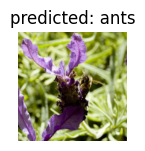

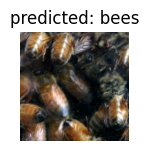

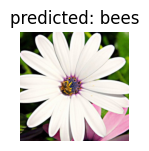

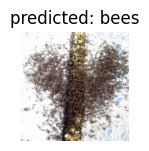

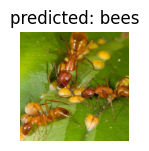

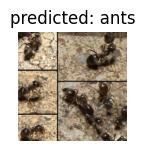

In [ ]:
# 수정된 ResNet18 모델 (model_conv)를 사용하여 검증 데이터셋의 이미지 예측을 시각화합니다.
visualize_model(model_conv)

# matplotlib의 인터랙티브 모드를 끕니다.
# 이렇게 해야 시각화된 이미지가 자동으로 업데이트되지 않고 정적으로 보존됩니다.
plt.ioff()

# 모든 시각화 그림을 표시합니다.
plt.show()


### 사용자 지정 이미지에 대한 추론
훈련된 모델을 사용하여 사용자 지정 이미지에 대한 예측을 수행하고 이미지와 함께 예측된 클래스 레이블을 시각화합니다.

이 부분에서는 훈련된 모델을 사용하여 새로운 이미지, 즉 학습 데이터 세트에 포함되지 않은 이미지에 대한 예측을 수행합니다. 이를 통해 모델이 실제 세계의 다양한 데이터에 얼마나 잘 일반화되는지를 확인할 수 있습니다. 예측된 클래스 레이블과 함께 원본 이미지를 시각적으로 표시하여 모델의 예측 정확도와 결과를 사용자에게 보여줍니다.



In [ ]:
def visualize_model_predictions(model, img_path):
    """
    모델을 사용하여 주어진 이미지의 예측 결과를 시각화하는 함수입니다.

    Parameters:
    - model (torch.nn.Module): 이미지 분류를 위한 학습된 모델
    - img_path (str): 분류할 이미지의 경로

    Returns:
    None
    """

    # 모델의 현재 학습 상태를 저장
    was_training = model.training
    # 모델을 평가 모드로 설정 (Dropout 및 BatchNorm 비활성화)
    model.eval()

    # 이미지 로딩 및 전처리
    img = Image.open(img_path)  # 이미지를 PIL 형식으로 로드
    img = data_transforms['val'](img)  # 이미지 전처리
    img = img.unsqueeze(0)  # 배치 차원 추가
    img = img.to(device)  # 이미지를 현재 작업 중인 장치 (CPU 또는 GPU)로 이동

    with torch.no_grad():  # 그래디언트 계산 비활성화
        outputs = model(img)  # 모델을 사용하여 이미지의 예측값 계산
        _, preds = torch.max(outputs, 1)  # 가장 확률이 높은 클래스의 인덱스 추출

    # 예측 결과와 이미지를 시각화
    ax = plt.subplot(2, 2, 1)
    ax.axis('off')  # 축 정보 숨김
    ax.set_title(f'Predicted: {class_names[preds[0]]}')  # 예측된 클래스 이름 표시
    imshow(img.cpu().data[0])  # 이미지 시각화

    # 모델의 원래 학습 상태로 복원
    model.train(mode=was_training)


In [ ]:
# `model_conv` 모델을 사용하여 지정된 이미지의 예측 결과를 시각화
visualize_model_predictions(
    model_conv,  # 사용할 모델
    img_path='/content/drive/MyDrive/data /hymenoptera_data/val/bees/72100438_73de9f17af.jpg'  # 예측을 수행할 이미지의 경로
)

# matplotlib의 대화식 모드를 끔 (다음 그림이 표시될 때까지 현재 그림의 업데이트를 중단)
plt.ioff()

# 지금까지의 모든 그림을 화면에 표시
plt.show()


FileNotFoundError: ignored

## 추가 학습
전송 학습의 응용에 대해 더 알고 싶다면, 컴퓨터 비전을 위한 [양자화된 전송 학습 튜토리얼](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html)을 확인해보세요.

이 부분에서는 전송 학습의 다양한 응용 분야에 대해 더 깊게 탐구하고자 하는 독자들에게 추가적인 학습 자료를 제공합니다. "양자화된 전송 학습"은 모델의 크기와 연산 부하를 줄이기 위해 사용되는 기술로, 이는 모바일 장치와 같은 자원이 제한된 환경에서 딥러닝 모델을 배포할 때 특히 유용합니다.


